# Fitting a Non-parametric Poisson Model with Parametric Model using SVI
## Theory
The theory follows much of the same approach as before. However, we are now working with models where the values $f$ are now latent variables, from which there exists a distribution of possible outcomes $y$ such that $y \sim p(y | f)$. The parametric and non-parametric models are parametric/non-parametric with respect to describing a distribution for $f$. They share the same likelihood $p(y|f)$. 

As before, the non-parametric model would in practice be some posterior of some model fit to the data. Let's take it to be $P(y|d)$, where $y$ denotes a measured outcome and $d$ denotes the data. This is typically referred to as the posterior predictive distribution of the mode. If we want to interpret the fit of this non-parametric model in terms of a parametric model, then the objective here would be for the parametric model to match the predictions of the GP model. To find such a parametric model, we must vary over a class of predictive distributions and find the one that best matches the predictions of the non-parametric model.

Let $\phi$ denote the hyperparameters affecting the shape of the final template distribution $p_{\phi}(y)$. Mathematically, our objective is met by matching the shape of $p_{\phi}(y)$ with $P(y|d)$. Thus, the objective is given by:
\begin{equation}
    \phi^{*} = \argmin_{\phi} KL[P(y|d) \ || \ p_{\phi}(y)].
\end{equation}
Here lies the key difference between this approach and the approach from the previous notebook. The above objective is to match the predictions $y$ between the two models. With $f$ playing the role of a latent variable in both models, we can still use the objective from the previous notebook. However, that objective instead focuses on matching the underlying distributions of the latent variable $f$ within the two models, rather than the distribution of predictions $y$. It is unclear whether or not both objectives should give the same $\phi^{*}$.  

Returning the objective above, it turns out we can pose the optimization problem in terms of an $ELBO$-like expression, as in the previous notebook. Let's start with choosing an order for the KL-divergence -- i.e., which distribution should take the first or second argument? Let's suppose we are taking Monte Carlo estimates of the KL-divergence using samples from one of the two distributions, either the parametric model $p_{\phi}(y)$ or non-parametric model $P(y|d)$. It is better to draw from the non-parametric model $P(y|d)$ since it has no dependence on $\phi$, simplifying any subsequent gradient descent. Therefore, we take
\begin{align}
KL[P(y|d) \ || \ p_{\phi}(y)] & =  \mathbb{E}_{P(y|d)}[\log P(y|d) - \log p_\phi (y)] \\
& \sim -\mathbb{E}_{P(y|d)}[\log p_{\phi}(y)],
\end{align}
where we omit the non-parametric log-likelihood term, as it has no effect on the fit.  The parametric log-likelihood is calculated by first sampling over some latent variables $z$, which are deterministically mapped to a rate, then sampled to a poisson count. That is, $p_{\phi}(y) = \int dz \ p(y|z) p_{\phi}(z) = \mathbb{E}_{p_{\phi}(z)}[p(y|z)]$. By making this expansion and using Jensens’ Inequality, we have a variational upper bound on the optimizable part of the KL-divergence.
$$
\begin{aligned}
KL[P(y|d) \ || \ p_{\phi}(y)] \lesssim  
-\mathbb{E}_{P(y|d)}[\mathbb{E}_{p_{\phi}(z)}[\log p(y | z)]]
\end{aligned}
$$
As in the previous approach, we come across an analog of maximum likelihood estimation. If we maximize the log-likelihood-like expression $\mathbb{E}_{P(y|d)}[\mathbb{E}_{p_{\phi}(z)}[\log p(y | z)]]$, then we significantly reduce our objective $KL[P(y|d) \ || \ p_{\phi}(y)]$.

It was much easier to convert the KL-divergence into the MLE analog here because we don't have to worry about the intermediate latent variable $f$ explicitly. That is taken care of by $p(y|z) = \int \ df \ p(y|f) \ p(f|z)$. 

## Conversion to SVI

As before, this approach is a lot like SVI. Let's convert the above formalism into a problem in SVI in order to perform the fit with existing $ELBO$-like optimization techniques. In SVI, we attempt to approximate the posterior $p(z|y)$ with a guide $q_{\phi}(z)$ by maximizing the $ELBO$ with respect to the guide hyperparameters $\phi$:
$$ 
\begin{aligned}
ELBO & = \mathbb{E}_{q_{\phi}(z)}[ \log p(y | z) - KL[q_{\phi}(z) || p(z)] ]. 
\end{aligned}
$$ 

Here’s a trick that I formalized -- but intuited by [smsharma](https://github.com/smsharma). In typical SVI, $y$ is fixed and the log-likelihood term depends mainly on the latent variables $z$. If we want to capture uncertainties associated with samples coming from a non-parametric model during the fit, we can accomplish that by resampling $y$ at each step of the fit. This transforms the $ELBO$ into $\mathbb{E}_{P(y|d)}[ELBO]$
$$
\begin{aligned}
    \mathbb{E}_{P(y|d)}[ELBO] = \mathbb{E}_{P(y|d)}[\mathbb{E}_{q_{\phi}(z)}[\log p(y | z)]] - KL[q_{\phi}(z) \ || \ p(z)].
\end{aligned}
$$
The first term here is the exact same objective function from the previous problem, upon making the replacement $q_{\phi}(z) \rightarrow p_{\phi}(z)$. Therefore, this SVI fit optimizes the desired objective, but penalizes deviations of the variational distribution $p_{\phi}(z)$ from an assumed prior $p(z)$. Unlike the previous approach, we will keep the additional KL-divergence term. See [Appendix A](#appendix-a-removing-kl-divergence-term-from-ELBO-with-numpyro) below for details on how to remove this regularization. 

For those who are more familiar with SVI, it may be easier to understand the above fit technique in terms of a heuristic argument presented in [Appendix B](#appendix-b-heuristic-explanation-of-fit-technique).

## `numpyro` Implementation
### Example: Fitting a Gaussian Rate Model (Parametric Model) to a Gaussian Process posterior (Non-parametric Model)
#### Generate Gaussian Process Posterior by performing SVI on Poisson Data
This is the same dataset that we use in the [sparse-tinygp](https://github.com/edwarddramirez/sparse-tinygp/blob/main/01_inference_sparse_gp.ipynb) repo. We use the most basic GP model from that notebook to define our non-parametric model. 

##### Dataset
We generate Poisson samples from a rate function that has a Gaussian shape. This is the same dataset that is used in the [sparse-tinygp](https://github.com/edwarddramirez/sparse-tinygp) repo. Specifically, the true data is drawn from the following distribution:

$$
\begin{aligned}
y_i & \sim \mathrm{Pois}[\lambda(x_i)] \\
\lambda(x_i) & = N \exp \left [-\frac{(x_i - \mu)^2}{2 \sigma^{2}} \right ],
\end{aligned}
$$
where $\mu = 0$, $\sigma = \pi$, and $N = 10$.

In [1]:
import sys
sys.path.append("..")
from utils import custom
from utils.custom import log_like_poisson

import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for plotting
import corner # for corner plots
from tqdm import tqdm # for progress bars

from tinygp import GaussianProcess, kernels # for Gaussian processes
import jax # for faster numerical operations
import jax.numpy as jnp # for numpy-like syntax
from jax.scipy import stats
from jax import jit
from jax.random import poisson

import numpyro # for inference and probabilistic programming
import numpyro.distributions as dist
from numpyro.infer import Predictive
from numpyro.handlers import block

/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


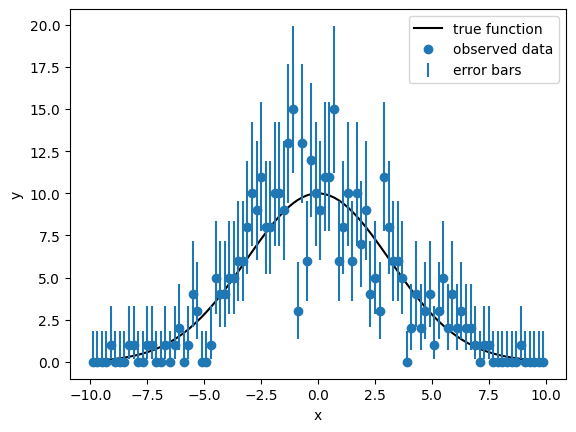

In [2]:
# parameters
p_tr = [0., np.pi, 10.]
mu_tr, sigma_tr, N_tr = p_tr

# generate data
x_bin = jnp.linspace(-10,10,101) # 10 random points between -1 and 1
x = 0.5 * (x_bin[:-1] + x_bin[1:])
log_rate = -(x-mu_tr)**2. / (2. * sigma_tr**2.)
y = N_tr * jnp.exp(log_rate)
y_obs = jax.random.poisson(jax.random.PRNGKey(23),y)

# estimate error bars
yerr = jnp.array([custom.poisson_interval(k) for k in y_obs.T]).T

# plot data with error bars
plt.plot(x, y, 'k', label='true function')
plt.plot(x, y_obs, 'o', label='observed data')
plt.errorbar(x, y_obs, yerr = yerr, c = 'C0', fmt = 'none', label='error bars')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

##### Obtain Approximate GP Posterior using SVI
We will take the nonparametric model $P(f | d)$ to be the approximate posterior $q_{\phi}$ obtained using SVI. We take a multivariate normal distribution as our guide via the `numpyro` [AutoMultivariateNormal](https://num.pyro.ai/en/latest/autoguide.html#numpyro.infer.autoguide.AutoMultivariateNormal) autoguide. This guide is loaded within the `load_svi` function in `util.custom.py`.

A summary of the model and the SVI optimization scheme is given below
$$
\begin{aligned}
    y_i & \sim \mathrm {Pois}\{ \exp ( f( x_i ) ) \} \\
    f & \sim \mathcal{GP}(0, k_{\theta}) \\
    q_{\phi}(f) & = \mathcal{N}(\mathbf{m}, \mathbf{\Sigma})(f).
\end{aligned}
$$
The GP describes the log-rate to ensure that samples of the rate ($\lambda$) are positive. The dimension in the guide multivariate normal corresponds to a value of $f(x_i)$ for input $x_i$.

In [3]:
def m1(x, y=None):
    '''
    Numpyro model for 1D Poisson regression with Gaussian Process prior on log_rate

    Parameters
    ----------
    x : array
        x values (where observations are made)
    y : array
        y values (observations)
    '''
    # define GP kernel (with hyperparameters optimized during fitting)
    kernel = custom.load_kernel(before_fit = True)

    # define Gaussian Process prior on log_rate (zero mean and ExpSquared kernel)
    gp = GaussianProcess(kernel, x, diag = 1e-3)
    log_rate = numpyro.sample("log_rate", gp.numpyro_dist())
    rate = jnp.exp(log_rate)
    
    # load function values and compute log likelihood
    numpyro.factor('log_likelihood', log_like_poisson(rate, y))

In [4]:
# run SVI
svi_1, g1 = custom.load_svi(m1, lr = 0.01, num_particles = 16)
rng_key = jax.random.PRNGKey(0)
svi_results_1 = svi_1.run(rng_key, 30000, x, y=y_obs)

100%|██████████| 30000/30000 [00:24<00:00, 1244.22it/s, init loss: 62861.3398, avg. loss [28501-30000]: 184.7116]


In [5]:
# sample from GP posterior using guide sample_posterior function
rng_key, key = jax.random.split(rng_key)
samples = g1.sample_posterior(key, svi_results_1.params, (1000,))
gp_samples = jnp.exp(samples['log_rate'])

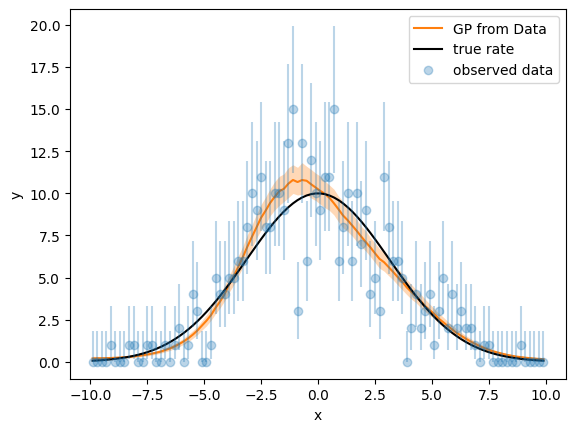

In [6]:
q1 = np.quantile(gp_samples, [0.16,0.5,0.84], axis = 0)

# plot guide (posterior approximation)
plt.plot(x, q1[1], color = 'C1', label = 'GP from Data')
plt.fill_between(
    x,
    q1[0],
    q1[2],
    alpha=0.3,
    lw=0,
    color="C1",
)

# plot data with error bars 
plt.plot(x, y, "k", label="true rate")
plt.plot(x, y_obs, 'o', label='observed data', alpha = 0.3)
plt.errorbar(x, y_obs, yerr = yerr, c = 'C0', fmt = 'none', alpha = 0.3)
plt.legend()
plt.xlabel("x")
_ = plt.ylabel("y")

#### Fitting a Parametric Model to the Non-parametric GP Model
We fit the non-parametric model to a simpler model consisting of Gaussian rate functions using the formalism above. The model is summarized below:
$$ 
\begin{aligned}
    \mathrm{SVI \ Objective} & = \mathbb{E}_{Q_{\phi^{*}}(y)}[\mathbb{E}_{q_{\phi}(z)}[\log p(y | z)]] - KL[q_{\phi}(z) \ || \ p(z)] \\
    f(x_i) & = \log \left [ N \exp \left (-\frac{(x_i - \mu)^2}{2 \sigma^{2}} \right ) \right ] \\
    \mu & \sim U[-10,10] \\
    \sigma & \sim U[0.001, 20] \\
    N & \sim U[0.001, 100],
\end{aligned}
$$
where $\phi^{*}$ is the optimal set of GP hyperparameters corresponding to the non-parametric model. Here, $Q_{\phi^{*}}(y)$ is $P(y|d)$ from the formalism above (i.e., the posterior predictive distribution of the GP model) and $q_{\phi}(z)$ corresponds to the SVI guide that we use for the parametric model when performing the fit to the non-parametric model. $p(y|z)$ is the Poisson likelihood, as shared by both parametric and non-parametric models.

Unlike the previous notebook, the priors will constrain the support of the parametric guide $q_{\phi}(z)$ and affect the value of the objective function during the fit. 

In [10]:
# we will re-sample y at each SVI step of the parametric fit with the help of the Predictive utility
g1_params = svi_results_1.params
pred = Predictive(g1, num_samples = 1, params = g1_params)

In [11]:
# SVI fit; modified to sample from GP at each SVI step
def m2(x, pred, gp_rng_key=None):
    '''
    Numpyro model for 1D Poisson regression with Gaussian Process prior on log_rate

    Parameters
    ----------
    x : array
        x values (where observations are made)
    pred : Predictive   
        Predictive utility for sampling from GP
    gp_rng_key : array
        random key for GP sampling
    '''
    # load kernel and sample from GP
    mu = numpyro.sample(
        "mu", dist.Uniform(-10, 10)
    )
    sigma = numpyro.sample(
        "sigma", dist.Uniform(0.0001, 20.)
    )
    N = numpyro.sample(
        "N", dist.Uniform(0.0001, 100.)
    )

    # compute rate and log rate as defined by parametric model
    rate = N * jnp.exp(-(x-mu)**2. / (2. * sigma**2.))

    # sample from GP posterior
    with numpyro.handlers.block(): # prevents g1 sites from being detected by numpyro
        lam = jnp.exp(pred(gp_rng_key, x)['log_rate']) 
        y = poisson(gp_rng_key, lam)

    # compute log likelihood
    numpyro.factor("log_likelihood", log_like_poisson(rate, y)) 

In [12]:
# run SVI
svi_2, g2 = custom.load_svi(m2, lr = 0.01, num_particles = 16)
rng_key, key = jax.random.split(rng_key)
svi_results_2 = custom.svi_loop_poisson(key, 10000, svi_2, x, pred)

100%|██████████| 10000/10000 [00:13<00:00, 754.06it/s]


In [13]:
# sample from GP posterior using guide sample_posterior function
rng_key, key = jax.random.split(rng_key)
temp_samples = g2.sample_posterior(key, svi_results_2.params, (1000,))
gauss_samples = temp_samples['N'][:,None] * np.exp(-(x[None,:]-temp_samples['mu'][:,None])**2. / (2. * temp_samples['sigma'][:,None]**2.))

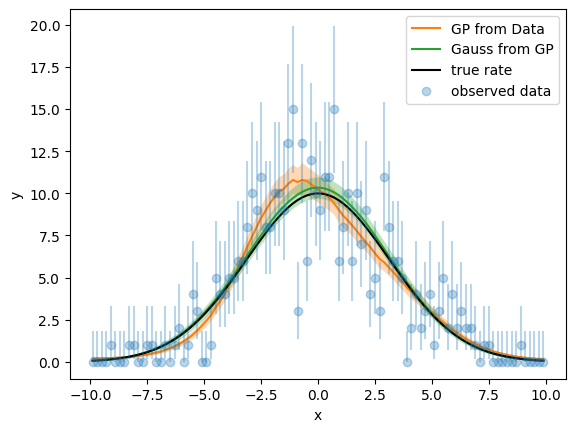

In [15]:
q2 = np.quantile(gauss_samples, [0.16,0.5,0.84], axis = 0)

# plot guide (posterior approximation)
plt.plot(x, q1[1], color = 'C1', label = 'GP from Data')
plt.fill_between(
    x,
    q1[0],
    q1[2],
    alpha=0.3,
    lw=0,
    color="C1",
)
plt.plot(x, q2[1], color = 'C2', label = 'Gauss from GP')
plt.fill_between(
    x,
    q2[0],
    q2[2],
    alpha=0.3,
    lw=0,
    color="C2",
)

# plot data with error bars 
plt.plot(x, y, "k", label="true rate")
plt.plot(x, y_obs, 'o', label='observed data', alpha = 0.3)
plt.errorbar(x, y_obs, yerr = yerr, c = 'C0', fmt = 'none', alpha = 0.3)
plt.legend()
plt.xlabel("x")
_ = plt.ylabel("y")

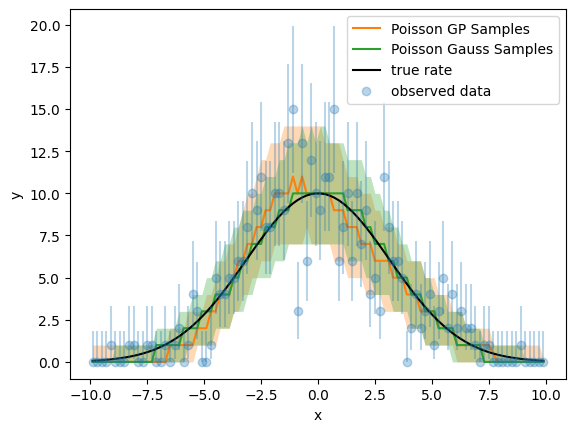

In [17]:
# plot poissonian predictive distributions of parametric and non-parametric models
rng_key, key = jax.random.split(rng_key)
poisson_gp_samples = poisson(key, gp_samples)

rng_key, key = jax.random.split(rng_key)
poisson_gauss_samples = poisson(key, gauss_samples)

q1 = np.quantile(poisson_gp_samples, [0.16,0.5,0.84], axis = 0)
q2 = np.quantile(poisson_gauss_samples, [0.16,0.5,0.84], axis = 0)

# plot guide (posterior approximation)
plt.plot(x, q1[1], color = 'C1', label = 'Poisson GP Samples')
plt.fill_between(
    x,
    q1[0],
    q1[2],
    alpha=0.3,
    lw=0,
    color="C1",
)
plt.plot(x, q2[1], color = 'C2', label = 'Poisson Gauss Samples')
plt.fill_between(
    x,
    q2[0],
    q2[2],
    alpha=0.3,
    lw=0,
    color="C2",
)

# plot data with error bars 
plt.plot(x, y, "k", label="true rate")
plt.plot(x, y_obs, 'o', label='observed data', alpha = 0.3)
plt.errorbar(x, y_obs, yerr = yerr, c = 'C0', fmt = 'none', alpha = 0.3)
plt.legend()
plt.xlabel("x")
_ = plt.ylabel("y")

**Remarks:** 
* From experience with more complicated fits, the parametric model's rate distribution has much lower variance than that of the non-parametric model. However, as shown here, the distributions of their Poisson samples exhibit similar variance, consistent with the objective of matching the *posterior predictive distributions* of the non-parametric and parametric models, as opposed to the underlying rate distributions.
* Getting the shapes of the variables within the `model` function to match correctly is a bit trickier for higher-dimensional problems.

## Appendix A: Removing KL-Divergence Term from ELBO with `numpyro`
#### My Easy But Hacky Implementation
This approach is easy to implement, but does not allow the user to adaptively change the ELBO during the SVI fit. An adaptive implementation is desirable because it can prevent the fitter from reaching pathological regions in the hyperparameter-space. See the existing implementations at the end of this appendix.

**Goal:**
$$
ELBO \rightarrow \mathbb{E}_{q}[\log [p(y |z]] - \beta \ KL[q \ || \ p]
$$
We can hard-code this KL-rescaling by working with the ELBO as calculated by NumPyro.
$$
\begin{aligned}
ELBO & = \mathbb{E}_q [\log p(y,z) - \log q(z)]  \\
& =\mathbb{E}_q [\log p(y | z) + \log p(z) - \log q(z)]  \\
\end{aligned}
$$
The last two terms form the KL-divergence. Therefore, adding the appropriate multiplicative factors to them accomplishes what we want. Here's how to do it.

First, to scale the prior term $\log p(z)$ by $\beta$, we can apply the numpyro `scale` handler on the prior samples in the `model` function:

```python
def model():
	...
	
	with numpyro.handler.scale(None, beta):
		a = numpyro.sample(...)
		b = numpyro.sample(...)
```

Second, we need to scale the guide term by $\beta$ as well. If we defined our own guide function, we would be able to do this by using the `scale` handler in the same way. However, for autoguides like in our examples, we don’t have that option. We hard-code this by modifying the $ELBO$ directly. In this version of `numpyro`, we make the following change to our local `numpyro/infer/elbo.py` file:
```diff
class Trace_ELBO(ELBO):
	...

	def single_particle_elbo(rng_key):
		...
		
		# log p(z) - log q(z)
- 		elbo_particle = model_log_density - guide_log_density
+ 		elbo_particle = model_log_density - beta * guide_log_density
```
In practice, we can't make $\beta = 0$ or too close to zero. But, the effect of the KL-term can be reduced in this way.

#### Existing and More Sophisticated Implementations:
* Point 7: [Customizing SVI objectives and training loops — Pyro Tutorials 1.9.0 documentation](https://pyro.ai/examples/custom_objectives.html)
* Near Bottom of Page: [Deep Markov Model — Pyro Tutorials 1.9.0 documentation](https://pyro.ai/examples/dmm.html)

## Appendix B: Heuristic Explanation of Fit Technique
The fit approach above makes a bit more sense when we take the SVI interpretation a bit more seriously. If our “data” is the posterior predictive distribution from the non-parametric fit, then it is a dataset consisting of infinite (i.i.d.) samples: $y_{\infty} = y_{1}, y_{2},...$ . Formally, there exists a posterior of our parametric model given this infinite data. 

Ignoring the KL-divergence term, the $ELBO$ is given by
$$
\begin{aligned}
ELBO & = \mathbb{E}_{q_{\phi}(z)}[\log p(y_\infty | z)] \\
& \sim \sum_{i} \mathbb{E}_{q_{\phi}(z)}[\log p(y_i | z)] \\
& \sim \mathbb{E}_{P(y|d)}[\mathbb{E}_{q_{\phi}(z)}[\log p(y | z)]]
\end{aligned}
$$

Notice, this is the same objective function that we have introduced above. The crucial difference of the objective function here is that it is explicitly made up of an infinite dataset. Therefore, we can only estimate it by using a finite subsample of this infinite data, just as we would do if we had a finite dataset that was too large. 

When subsampling, the best practice is to randomly generate the subsample at each SVI step. This random sampling of subsamples is exactly what our code does, we just didn't acknowledge that it was subsampling from an infinite dataset. Thus, we aren’t really using SVI to hack our way into optimizing our desired objective. We are performing the SVI as before, just with an infinite dataset.